In [1]:
import JSSP
import time
import numpy as np
import random
import gym
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.style
import os
import time

# Environment Initialization

In [2]:
def create_env(instance_path):
    env_name = "JSSP-v0"
    env = gym.make(env_name, instance_path = instance_path)
    print("Environment Created for: ", instance_path)
    print("Observation space: \n", env.observation_space)
    print("Action space: \n", env.action_space)
    return env

In [3]:
env1 = create_env("Instances/instance1.txt") # -53
env3 = create_env("Instances/instance3.txt") #-981
env4 = create_env("Instances/instance4.txt")
env5 = create_env("Instances/instance5.txt")

/Users/boyanggu/RL-Research-2022-Summer/JSSP/envs/JSSP_env.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.observation_space = gym.spaces.Box(low=lower_bound_temp, high=upper_bound_temp, dtype=np.int)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old 

Environment Created for:  Instances/instance1.txt
Observation space: 
 Box([-2 -2  0  0], 2, (4,), int64)
Action space: 
 Discrete(7)
Environment Created for:  Instances/instance3.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], [10 10 10 10 10 10 10 10 10 10  9  9  9  9  9  9  9  9  9  9], (20,), int64)
Action space: 
 Discrete(259)
Environment Created for:  Instances/instance4.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2 -2 -2 -2 -2  0  0  0  0  0  0  0  0  0  0], 5, (20,), int64)
Action space: 
 Discrete(755)
Environment Created for:  Instances/instance5.txt
Observation space: 
 Box([-2 -2 -2 -2 -2 -2  0  0  0  0  0  0], 5, (12,), int64)
Action space: 
 Discrete(15)


# Baselines

## 1. Q-Learning

We use Q-learning to illustrate instance division algorithm, but it is not based on any scheduling algorithms. Instance division only provides a method to split the main scheduling problem into many sub-problems. Actually, ordinary Q-learning still fail to converge for large instance when instance division algorithm is applied. So the optimal solution is to combine prepopulated Q-table algorithm with instance division.

In [4]:
def get_machine_allocation(state):
    """
    function that returns the machine allocation information at current state
    :param state: current state which is a tuple of order 2 * number of jobs
    :return: a list of order of number of jobs containing the machine allocation information at current state
    """
    state = list(state)
    # machine_allocation = state[:len(state) // 3]
    machine_allocation = state[:len(state) // 2]
    return machine_allocation

In [5]:
def get_operation_status(state):
    """
    function that returns the operation status information at current state
    :param state: current state which is a tuple of order 2 * number of jobs
    :return: a list of order of number of jobs containing the operation status information at current state
    """
    state = list(state)
    # operation_status = state[len(state) // 3:2*len(state) // 3]
    operation_status = state[len(state) // 2:]
    return operation_status

In [6]:
def get_minimum_left_time(job, operation_index, job_operation_map):
    """
    function that returns the minimum time for current job to finish all operations
    It will search through all leftover operations and sum up the minimum
    :param job: job index
    :param operation_index: which operation is this job doing or waiting to do
    :param job_operation_map: the dictionary that covers information about the time each machine will take to finish each operation of each job
    :return: minimum time for this job to finish all leftover operations
    """
    map = job_operation_map[job] # part of the job_operation_map that is related to current job
    minimum_time = 0
    operation_no = sorted(map)[-1]
    if operation_index == operation_no:
        return 1
    for operation in range(int(operation_index) + 1, operation_no + 1):
        minimum_time += np.min([time for time in map[operation] if time != -1])
    return minimum_time

In [7]:
def heuristic_makespan(state, env):
    """
    function that returns the minimum time for current state to finish all jobs
    It will search through all jobs and return the maximum of minimum left time of all jobs
    :param state: current state which is a tuple of order 2 * number of jobs
    :param env: JSSP instance
    :return: heuristic minimum time for current state to finish all jobs
    """
    operations = get_operation_status(state)
    minimum_makespan = 0
    for job in range(env.job_total):
        job_minimum_left_time = get_minimum_left_time(job, operations[job], env.job_operation_map)
        # Choose the maximum leftover time
        if job_minimum_left_time > minimum_makespan:
            minimum_makespan = job_minimum_left_time
    return minimum_makespan

In [8]:
def get_action(state, Q, Q_indicator, epsilon):
    """
    function that choose action in a smart way
    If all jobs are waiting or done with all operations, then we will not choose the last action(wait action) since it is definitely a bad move.
    :param state: current state which is a tuple of order 2 * number of jobs
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param epsilon: randomness factor, how random the selection is
    :param num_actions: number of actions for the current state
    :return: an index of which action will be chosen
    """
    not_fully_explored_actions_index = np.logical_not(Q_indicator[state])
    not_fully_explored_num_actions = np.sum(not_fully_explored_actions_index)
    if not_fully_explored_num_actions == 0:
        epsilon = 0
        not_fully_explored_num_actions = 1
    # If in the state all jobs are waiting or done with all operation, choose action based on epsilon-greedy algorithm while making sure we won't choose the wait action at all
    best_action = np.argmax(Q[state])
    action_probabilities = not_fully_explored_actions_index * epsilon / not_fully_explored_num_actions
    action_probabilities[best_action] += (1.0 - epsilon)
    action = np.random.choice(np.arange(len(action_probabilities)), p = action_probabilities)
    return action

In [9]:
def update(Q, state, next_state, action, reward, eta, gamma, env):
    """
    Q-table updating step
    :param Q: Q table which is a dictionary with states as first class keys and actions as second class keys
    :param state: current state which is a tuple of order 2 * number of jobs
    :param next_state: next state which is a tuple of order 2 * number of jobs
    :param action: action between current state and next state
    :param reward: reward for the action
    :param eta: learning rate
    :param gamma: discounted factor
    :param env: JSSP instance
    :return: updated Q table
    """
    # If Q-table hasn't reached the next state before, using the heuristic function to approximate the maximum Q-value of the next state
    if next_state not in Q:
        Q_next_state_max = -heuristic_makespan(next_state, env)
    else:
        Q_next_state_max = max(Q[next_state])

    # Updating step
    learning = reward + gamma * Q_next_state_max - Q[state][action]
    Q[state][action] += eta * learning

    return Q, learning

In [10]:
def get_final_state(env):
    machine_allocation = [-2] * env.job_total
    operation_status = [len(env.job_operation_map[job]) for job in range(env.job_total)]
    return tuple(machine_allocation + operation_status)

instance separation

In [11]:
def get_end_data(separation_history_data):
    end_times = [int(job_history[-1][-1]) if job_history != [] else 0 for job_history in separation_history_data]
    end_machines = [job_history[-1][0] if job_history != [] else None for job_history in separation_history_data]
    return end_times, end_machines

In [12]:
def write_in_job_data(file, full_job_data, start_operation, writein_total_operations):
    full_job_data = full_job_data.split()
    full_job_data = [int(x) for x in full_job_data]
    operation_total = full_job_data[0]
    del full_job_data[0]
    assert operation_total > start_operation, 'Intermediate mode: Wrong starting operation'
    assert operation_total > start_operation + writein_total_operations - 1, 'Intermediate mode: Wrong total operations'
    for _ in range(start_operation):
        available_machine_total = full_job_data[0]
        del full_job_data[:2 * available_machine_total + 1]
    writein_data = [writein_total_operations]
    for _ in range(writein_total_operations):
        available_machine_total = full_job_data[0]
        writein_data.extend(full_job_data[:2 * available_machine_total + 1])
        del full_job_data[:2 * available_machine_total + 1]
    writein_data = [str(x) for x in writein_data]
    writein_data = ' '.join(writein_data) + '\n'
    file.write(writein_data)

In [13]:
def create_separate_instance(file_name, separation):
    file = open(file_name, 'r')
    file_new = open('sub_instance.txt', 'w')
    lines = file.readlines()
    file.close()
    job_total, machine_total = [int(x) for x in lines[0].split()]
    start_operations = np.zeros(job_total, dtype = int)
    file_new.write(lines[0])
    for i in range(job_total):
        write_in_job_data(file_new, lines[i+1], start_operations[i], separation[i])
    file_new.close()
    env = create_env('sub_instance.txt')
    os.remove('sub_instance.txt')
    return env

In [14]:
def create_separation_lists_by_time(env, separation_no, operation_time_approximation = 'mean'):
    job_operation_time_approximation_list = []
    max_time = 0
    for job in range(env.job_total):
        current_job_operation_time_list = []
        for operation in range(len(env.job_operation_map[job])):
            operation_data = env.job_operation_map[job][operation]
            valid_operation_data = [time for time in operation_data if time != -1]
            if operation_time_approximation == 'mean':
                current_job_operation_time_list.append(np.mean(valid_operation_data))
            if operation_time_approximation == 'median':
                current_job_operation_time_list.append(np.median(valid_operation_data))
            if operation_time_approximation == 'max':
                current_job_operation_time_list.append(np.max(valid_operation_data))
            if operation_time_approximation == 'min':
                current_job_operation_time_list.append(np.min(valid_operation_data))
        job_operation_time_approximation_list.append(current_job_operation_time_list)
        if np.sum(current_job_operation_time_list) > max_time:
            max_time = np.sum(current_job_operation_time_list)
    separation_time = max_time / separation_no
    all_jobs_separation = []
    for job in range(env.job_total):
        current_job_operation_time_list = job_operation_time_approximation_list[job]
        cummulative_time = 0
        cummulative_operation = 0
        job_separation = []
        for operation in range(len(current_job_operation_time_list)):
            cummulative_operation += 1
            cummulative_time += current_job_operation_time_list.pop(0)
            if cummulative_time > separation_time:
                job_separation.append(cummulative_operation)
                cummulative_time = 0
                cummulative_operation = 0
        if cummulative_operation != 0:
            job_separation.append(cummulative_operation)
        job_separation += [0] * (separation_no - len(job_separation))
        all_jobs_separation.append(job_separation)
    separation_list = np.array(all_jobs_separation).T
    for i in range(1, len(separation_list)):
        separation_list[i] = separation_list[i - 1] + separation_list[i]
    return separation_list.tolist()

In [15]:
def create_separation_lists_by_no_of_operations(env, separation_no):

    separation_list = []
    for i in range(separation_no):
        separation = [len(env.job_operation_map[job]) // separation_no
                        if i > (len(env.job_operation_map[job]) % separation_no) - 1
                        else len(env.job_operation_map[job]) // separation_no + 1
                        for job in range(env.job_total)]
        separation_list.append(separation)

    for i in range(1, len(separation_list)):
        separation_list[i] = list(np.array(separation_list[i - 1]) + np.array(separation_list[i]))

    return separation_list

In [16]:
def create_separation_lists(env, separation_category, separation_no):
    if separation_category == 'by time':
        return create_separation_lists_by_time(env, separation_no)
    if separation_category == 'by no of operations':
        return create_separation_lists_by_no_of_operations(env, separation_no)

In [17]:
def get_legal_allocations(env, schedule_constrains):
    """
    returns next available legal allocations
    legal allocations requires:
    1. machine operation pair is legal
    2. job is not allocated
    3. machine is not allocated
    :return: list of list of numbers
    ex. {
            0: [0, 1]
            1: []
            2: [0, 2]
    }
    at current state, jobs 1, 3 are free
    for 1st job, machines 1, 2 are legal
    for 2nd job, no machines are free
    for 3rd job, machines 1, 3 are legal
    """
    legal_allocations = []
    for job in range(env.job_total):
        # legal actions requires:
        # 1. machine operation pair is legal
        # 2. job is not allocated or finished
        # 3. machine is not allocated
        if env.time < schedule_constrains[job][-1][-1]:
            schedule_constrains_start_times = [job_history[1] for job_history in schedule_constrains[job]]
            if env.time in schedule_constrains_start_times:
                free_legal_machines = [schedule_constrains[job][schedule_constrains_start_times.index(env.time)][0]]
            else:
                free_legal_machines = [-1]
        else:
            current_operation = env.state[env.job_operation_status][job]
            job_machine_allocation = env.state[env.job_machine_allocation]
            if current_operation == -1:
                free_legal_machines = []
            else:
                job_operation_machine_time = env.job_operation_map[job][current_operation]
                legal_machines = np.array([i for i in range(env.machine_total)
                                           if job_operation_machine_time[i] >= 0])
                free_legal_machines = [i for i in legal_machines
                                       if job_machine_allocation[job] == -1
                                       if i not in job_machine_allocation]
            free_legal_machines.append(-1)
        legal_allocations.append(free_legal_machines)

    return legal_allocations

In [18]:
def generate_legal_allocation_list(env, legal_allocation_map, legal_allocation_index, schedule_constrains):
    """
    generates legal_action_allocation_list:
    legal actions requires:
    1. machine operation pair is present in the FJSSP instance
    2. job is not assigned or finished
    3. machine is not assigned
    4. no duplicate job or machine assignments
    5. if all jobs are idle, wait is not allowed
    we check the first 3 conditions in get_legal_allocations
    """
    current_obs = env.get_obs()
    if current_obs in legal_allocation_map:
        legal_allocation_list = legal_allocation_map[current_obs]
        return legal_allocation_list, legal_allocation_map, legal_allocation_index
    legal_allocations = get_legal_allocations(env, schedule_constrains)
    allocation_list = list(itertools.product(*legal_allocations))
    legal_allocations_list = []
    for allocation in allocation_list:
        # 4. check for duplicate job allocation
        duplicate_check_list = [machine for machine in allocation if machine != -1]
        if len(np.unique(duplicate_check_list)) == len(duplicate_check_list):
            legal_allocations_list.append(np.array(allocation))
    # 5. check if no job is working
    all_job_idle = np.all(env.state[env.job_machine_allocation] < 0)
    all_waiting_action = np.array([-1] * env.job_total)
    if all_job_idle and np.all(all_waiting_action == legal_allocations_list[-1]):
        legal_allocations_list.pop()
    legal_allocation_map[current_obs] = legal_allocations_list

    legal_allocations_list_without_constrains = env.legal_allocation_map[current_obs]
    legal_allocations_list_without_constrains = np.array(legal_allocations_list_without_constrains).tolist()
    legal_allocation_index[current_obs] = [legal_allocations_list_without_constrains.index(allocation.tolist()) for allocation in legal_allocations_list]

    return legal_allocations_list, legal_allocation_map, legal_allocation_index

In [19]:
def q_learning(env, epochs, schedule_constrains, eta = .628, gamma = 1, epsilon = .1, max_epsilon_greedy_episodes = 1000, max_convergence_episodes = 50000, convergence_guarantee_episodes = 100):
    """
    q-learning algorithm that returns the best policy, and data for each episode
    :param env: JSSP instance
    :param epis: number of episodes
    :param eta: learning rate, how much you accept the new value vs the old value
    :param gamma: discount factor, balance immediate and future reward
    :param epsilon: randomness factor, how random the selection is
    :return: a list of total reward for each episode, the final Q_table, and a list of total reward every 100 episodes
    """
    max_score = -100000
    max_episode = -1
    max_action_list = []
    max_time_list = []
    max_jobs_history = []

    # Parameters of Q-learning
    Q_table = {}
    Q_convergence_indicator_table = {}
    legal_allocation_map = {}
    legal_allocation_index = {}
    total_reward_list = [] # rewards per episode calculate
    testing_reward_list = []
    episode_no = 1

    # Update the final done state
    final_state = get_final_state(env)
    Q_table[final_state] = np.array([0])
    Q_convergence_indicator_table[final_state] = np.array([True])

    for epoch in range(epochs):
        # Q-learning Algorithm
        current_epsilon = epsilon
        for episode in range(max_epsilon_greedy_episodes):
            # Reset environment
            state = env.reset()
            total_reward = 0
            done = False
            action_list = []
            time_list = []

            # The Q-Table learning algorithm
            while not done:
                if state not in Q_table:
                    legal_allocations_list, legal_allocation_map, legal_allocation_index = generate_legal_allocation_list(env, legal_allocation_map, legal_allocation_index, schedule_constrains)
                    Q_table[state] = np.negative(np.full(len(legal_allocations_list), heuristic_makespan(state, env), dtype = float))
                    Q_convergence_indicator_table[state] = np.full(len(legal_allocations_list), False)
                action = get_action(state, Q_table, Q_convergence_indicator_table, current_epsilon)
                actual_action = legal_allocation_index[state][action]
                # Only record the action in history if it is not a wait action
                if actual_action != env.action_space.n -1:
                    action_list.append(env.legal_allocation_list[actual_action])
                    time_list.append(env.time)
                # Get new state & reward from environment
                next_state, reward, done, _ = env.step(actual_action)
                # Update Q-Table with new knowledge
                Q_table, learning = update(Q_table, state, next_state, action, reward, eta, gamma, env)
                if abs(learning) <= .001 and next_state in Q_convergence_indicator_table and np.all(Q_convergence_indicator_table[next_state]):
                    Q_convergence_indicator_table[state][action] = True
                if Q_convergence_indicator_table[state][action] == True:
                    total_reward += round(reward + max(Q_table[next_state]))
                    break
                total_reward += reward
                state = next_state
            # Record policy result and store it as policy testing result every 100 episodes
            total_reward_list.append(total_reward)
            episode_no += 1
            if episode % 100 == 0:
                testing_reward_list.append(total_reward)
            # Record the best policy
            if total_reward >= max_score:
                max_score = total_reward
                max_episode = episode
                max_action_list = action_list
                max_time_list = time_list
                max_jobs_history = env.jobs_history
            print("Episode: " + str(episode) + " has time " + str(env.time))

        current_epsilon = 0
        convergence_no = 1
        for episode in range(max_convergence_episodes):
            # Reset environment
            state = env.reset()
            total_reward = 0
            done = False
            action_list = []
            time_list = []

            # The Q-Table learning algorithm
            while not done:
                if state not in Q_table:
                    legal_allocations_list, legal_allocation_map, legal_allocation_index = generate_legal_allocation_list(env, legal_allocation_map, legal_allocation_index, schedule_constrains)
                    Q_table[state] = np.negative(np.full(len(legal_allocations_list), heuristic_makespan(state, env), dtype = float))
                    Q_convergence_indicator_table[state] = np.full(len(legal_allocations_list), False)
                action = get_action(state, Q_table, Q_convergence_indicator_table, current_epsilon)
                actual_action = legal_allocation_index[state][action]
                # Only record the action in history if it is not a wait action
                if actual_action != env.action_space.n -1:
                    action_list.append(env.legal_allocation_list[actual_action])
                    time_list.append(env.time)
                # Get new state & reward from environment
                next_state, reward, done, _ = env.step(actual_action)
                # Update Q-Table with new knowledge
                Q_table, learning = update(Q_table, state, next_state, action, reward, eta, gamma, env)
                if abs(learning) <= .001 and next_state in Q_convergence_indicator_table and np.all(Q_convergence_indicator_table[next_state]):
                    Q_convergence_indicator_table[state][action] = True
                if Q_convergence_indicator_table[state][action] == True:
                    total_reward += round(reward + max(Q_table[next_state]))
                    break
                total_reward += reward
                state = next_state
            # Update the final done state
            if state not in Q_table:
                Q_table[state] = np.array([0])
            if total_reward == total_reward_list[-1]:
                convergence_no += 1
            else:
                convergence_no = 1
            # Record policy result and store it as policy testing result every 100 episodes
            total_reward_list.append(total_reward)
            if episode % 100 == 0:
                testing_reward_list.append(total_reward)
            # Record the best policy
            if total_reward >= max_score:
                max_score = total_reward
                max_episode = episode
                max_action_list = action_list
                max_time_list = time_list
                max_jobs_history = env.jobs_history
            print("Episode: " + str(episode) + " has time " + str(env.time))
            if convergence_no == convergence_guarantee_episodes:
                break

    print('From {}th Episode best policy has reward {}'.format(max_episode + 1, max_score))
    for i in range(len(max_action_list)):
        print('The allocation chose at time {} is {}'.format(max_time_list[i], max_action_list[i]))

    return total_reward_list, Q_table, testing_reward_list, max_jobs_history

test on env1

In [20]:
create_separation_lists(env1, 'by time', 2)

[[2, 2], [2, 3]]

In [21]:
schedule_constrains = [[[-1,-1,-1]], [[-1,-1,-1]]]
env1_1 = create_separate_instance("Instances/instance1.txt", [2,2])
training_reward_list, Q_table, testing_reward_list, schedule_constrains = q_learning(env1_1, 3, schedule_constrains)
env1_2 = create_separate_instance("Instances/instance1.txt", [2,3])
training_reward_list, Q_table, testing_reward_list, max_jobs_history = q_learning(env1_2, 3, schedule_constrains)

Environment Created for:  sub_instance.txt
Observation space: 
 Box([-2 -2  0  0], [2 2 1 1], (4,), int64)
Action space: 
 Discrete(7)
Episode: 0 has time 50
Episode: 1 has time 44
Episode: 2 has time 45
Episode: 3 has time 45
Episode: 4 has time 45
Episode: 5 has time 47
Episode: 6 has time 46
Episode: 7 has time 50
Episode: 8 has time 47
Episode: 9 has time 52
Episode: 10 has time 46
Episode: 11 has time 52
Episode: 12 has time 50
Episode: 13 has time 50


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:175: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  "Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator."
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:191: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  "Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting."
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gym/utils/passive_env_checker.py:196: UserWarning: WARN: Future gym 

Episode: 14 has time 38
Episode: 15 has time 62
Episode: 16 has time 50
Episode: 17 has time 50
Episode: 18 has time 57
Episode: 19 has time 49
Episode: 20 has time 48
Episode: 21 has time 51
Episode: 22 has time 50
Episode: 23 has time 39
Episode: 24 has time 47
Episode: 25 has time 52
Episode: 26 has time 51
Episode: 27 has time 40
Episode: 28 has time 50
Episode: 29 has time 44
Episode: 30 has time 58
Episode: 31 has time 46
Episode: 32 has time 56
Episode: 33 has time 42
Episode: 34 has time 50
Episode: 35 has time 39
Episode: 36 has time 39
Episode: 37 has time 50
Episode: 38 has time 45
Episode: 39 has time 50
Episode: 40 has time 41
Episode: 41 has time 43
Episode: 42 has time 41
Episode: 43 has time 45
Episode: 44 has time 38
Episode: 45 has time 38
Episode: 46 has time 39
Episode: 47 has time 50
Episode: 48 has time 48
Episode: 49 has time 46
Episode: 50 has time 45
Episode: 51 has time 40
Episode: 52 has time 53
Episode: 53 has time 50
Episode: 54 has time 49
Episode: 55 has 

# Analysis

## QLearning

For small instance it converges really quick so the entire plot contains only the random epsilon greedy trials.

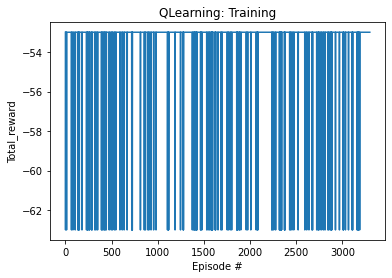

In [22]:
plt.plot(training_reward_list)
plt.title("QLearning: Training")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()

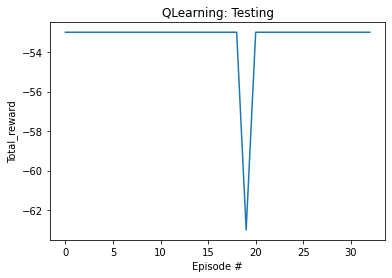

In [23]:
plt.plot(testing_reward_list)
plt.title("QLearning: Testing")
plt.xlabel("Episode #")
plt.ylabel("Total_reward")
plt.show()